In [1]:
from hossam import load_data
from pandas import DataFrame,get_dummies, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

#클러스터링 관련 참조
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

#Elbow Point 계산 라이브러리
from kneed import KneeLocator

# 정규성 검정 라이브러리
from scipy.stats import normaltest

#데이터 전처리 라이브러리
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#실루엣 스코어 라이브러리
from sklearn.metrics import silhouette_samples, silhouette_score

from matplotlib import cm
my_dpi=200

In [10]:
origin = load_dataorigin = load_data('customer')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")

print(origin.info())

origin.head()

customer는 존재하지 않는 데이터에 대한 요청입니다.

===== 데이터 크기 확인 =====


AttributeError: 'NoneType' object has no attribute 'shape'

# 데이터 탐색 및 전처리

In [ ]:
#인덱스 지정
df = origin.set_index("고객ID")
df.head()

,성별,나이,연수입,지출점수
고객ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [ ]:
#정규분포 여부 확인
fields = ["나이", "연수입", "지출점수"]

for f in fields:
    stat, p = normaltest(df[f])
    alpha = 0.05
    print(f"\n===== {f} 정규성 검정 =====")
    print(f"stat={stat}, p={p}")
    if p> alpha:
        print(f"{f}는 정규분포를 따릅니다 (귀무가설 채택)")
    else:
        print(f"{f}는 정규분포를 따르지 않습니다 (귀무가설 기각)")


===== 나이 정규성 검정 =====
stat=15.577514003752057, p=0.000414367622180182
나이는 정규분포를 따르지 않습니다 (귀무가설 기각)

===== 연수입 정규성 검정 =====
stat=3.5109953115353187, p=0.17282121541298148
연수입는 정규분포를 따릅니다 (귀무가설 채택)

===== 지출점수 정규성 검정 =====
stat=16.302230221326983, p=0.0002884135672001835
지출점수는 정규분포를 따르지 않습니다 (귀무가설 기각)


In [ ]:
# 정규뷴포를 따르지 않는 데이터에 대해서 표준화 적용
scale_df = df[["나이", "연수입", "지출점수"]].copy()
scaler = StandardScaler()
sdf = DataFrame(
    scaler.fit_transform(scale_df), columns=scale_df.columns, index = scale_df.index
)
sdf.insert(0, "성별", df["성별"])
sdf

,성별,나이,연수입,지출점수
고객ID,,,,
1,Male,-1.424569,-1.738999,-0.434801
2,Male,-1.281035,-1.738999,1.195704
3,Female,-1.352802,-1.700830,-1.715913
4,Female,-1.137502,-1.700830,1.040418
5,Female,-0.563369,-1.662660,-0.395980
...,...,...,...,...
196,Female,-0.276302,2.268791,1.118061
197,Female,0.441365,2.497807,-0.861839
198,Male,-0.491602,2.497807,0.923953


##  명목형 변수 인코딩

In [ ]:

df_dummies = get_dummies(sdf, columns=["성별"], dtype="int", drop_first=False)
df_dummies.head()

,나이,연수입,지출점수,성별_Female,성별_Male
고객ID,,,,,
1,-1.424569,-1.738999,-0.434801,0,1
2,-1.281035,-1.738999,1.195704,0,1
3,-1.352802,-1.700830,-1.715913,1,0
4,-1.137502,-1.700830,1.040418,1,0
5,-0.563369,-1.662660,-0.395980,1,0


## 엘로우 포인트 구하기

In [ ]:
# 적절한 범위 내에서 이너셔 값 생성

klist = list(range(3,11))
inertia = [] #indertia값을 저장할 리스트

for k in klist:
    estimator = KMeans(n_clusters=k, random_state=52)
    estimator.fit(X=df_dummies)
    inertia.append(estimator.inertia_)
inertia

[393.5986115835211,
 304.3074053388816,
 284.3453955595961,
 245.03129918573325,
 237.7227000085023,
 197.75874820044876,
 173.3303339679523,
 163.9166081964125]

In [ ]:
# 최적의 k값 (엘보우 포인트)도출
kl = KneeLocator(klist, inertia, curve="convex", direction="decreasing", S=0.1)
best_k = kl.elbow
best_y = kl.elbow_y
print("found elbow:", best_k)
print("found y: ", best_y)

found elbow: 4
found y:  304.3074053388816


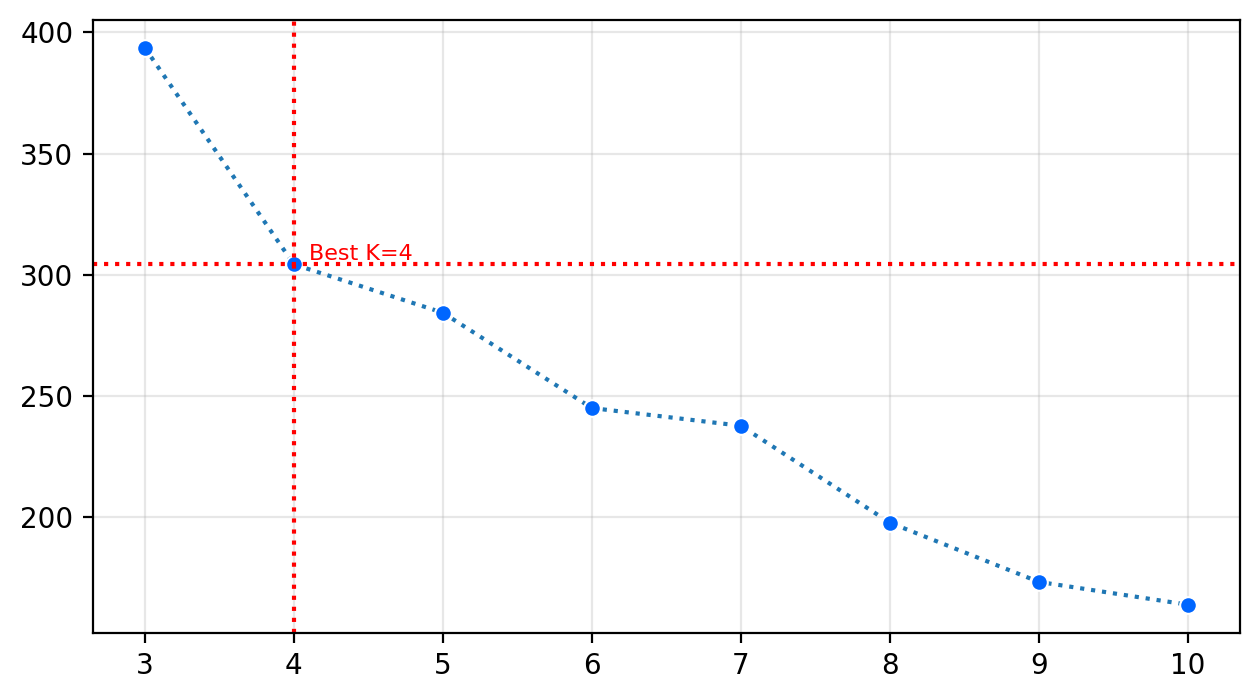

In [ ]:
#시각화 확인
figsize = (1280/ my_dpi, 720/my_dpi)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=my_dpi)

# LinePlot그리기
sb.lineplot(
    x=klist,
    y=inertia,
    linestyle=":",
    marker="o",
    markerfacecolor="#0066ff",
    markeredgecolor="#ffffff"
)
#엘보우 포인트 표시
if best_k is not None:
    ax.axvline(x=best_k, color="red", linestyle=":")
    ax.axhline(y=best_y, color="red",linestyle=":")
    ax.text(
        best_k +0.1,
        best_y +0.1,
        "Best K=%d" % best_k,
        fontsize=8,
        ha="left",
        va="bottom",
        color="r",
    )
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()
    

## 엘보우 포인트 검증(실루엣 스코어)

In [17]:
# 실루엣 스코어 시각화 함수 정의
def visualize_silhouette(estimator, X_features):
    fig, (ax1, ax2 ) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    sil_avg = silhouette_score(X=X_features, labels=estimator.labels_)
    sil_values = silhouette_samples(X=X_features, labels=estimator.labels_)

    y_lower =10
    plt.suptitle(
        "Number of Cluster :" + str(estimator.n_clusters)+","
        "Silhouette Score :" +str(round(sil_avg,3))

    )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlime([-0.1, 1])
    ax1.set_ylime([0, len(X_features)+ (estimator.n_clusters +1)*10])
    ax1.set_yticks([]) #Clear the yaxis labels/ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8,1])
    ax1.grid()

    #클러스터링 갯수별로 fill_betweenx()형태의 막대 그래프 표현.
    for i in range(estimator.n_clusters):
        ith_cluster_sil_values = sil_values[estimator.labels_ == i]
        ith_cluster_sil_values.sort()

        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i)/ estimator.n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sil_values,
            facecolor = color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower +0.5*size_cluster_i, str(i))
        y_lower=y_upper +10

    ax1.axvline(x=sil_avg, color = "red", linestyle="--")

    #2nd Plot showing the actual clusters formed
    color = cm.nipy_spectral(estimator.labels_.astype(float)/estimator.n_clusters)
    ax2.scatter(
        X_features[X_features.columns[0]],
        X_features[X_features.columns[1]],
        marker="o",
        s=30,
        lw=0,
        alpha=0.7,
        c=color,
        edgecolor="k"
    )
    # Labeling the clusters
    centers = estimator.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:,0],
        centers[:,1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="r",
    )

    for i,c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%ds" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.grid()

    plt.show()
    plt.close()

In [18]:
#군집수별 실루엣 스코어 확인
##시작값은 최소 군집수 (분석가 주관으로 결정)
klist = list(range(3,11))
silhouette = []       #실루엣 스코어를 저장할 리스트


for k in klist:
    estimator = KMeans(n_clusters=k, random_state=52)
    estimator.fit(X=df_dummies)
    cluster = estimator.predict(df_dummies)
    s_score = silhouette_score(X=df_dummies, labels=cluster)
    silhouette.append(s_score)
    #visualize_silhouette(estimator=estimator, X_features=df_encode)

silhouette_df = DataFrame({"k": klist, "silhouette_score":silhouette})
silhouette_df

NameError: name 'df_dummies' is not defined

최적의 k는 4로 선택하는 것이 타당함
-엘보우 포인트가 4에서 도출되어 군집의 응집도가 급격히 완화되는 지점임
-실루엣 스코어도 k=4에서 0.318로, 전체 구간 중 가장 높은 값에 근접함

실루엣 스코어의 해석
-k=4에서 실루엣 스코어가 가장 높지는 않지만(최고값은 k=9,0.339), k가 커질수록 군집의 해석력과 실용성이 떨어질 수 있음.
-실루엣 스코어가 0.3이상이면 군집 품질이 양호한 편임
결론
-엘보우 포인트와 실루엣 스코어 모두를 고려할 때, k=4가 군집의 응집도와 해석력, 실용성 측면에서 최적임
-데이터의 특성과 분석 목적에 따라 k=4를 선택하는 것이 가장 합리적임.


# 최종 모형 적합

In [19]:
#군집 분석
estimator = KMeans(n_clusters=best_k, random_state=52)
estimator.fit(X=df_dummies)
clusters = estimator.predict(df_dummies)

cdf= df_dummies.copy()
cdf["ClusterID"] =clusters
cdf.head()

NameError: name 'best_k' is not defined

In [23]:
vdf = cdf.copy()
hue_field = "ClusterID"
x_field = cdf.columns[1]
y_field = cdf.columns[2]

figsize = (1280/ my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

#데이터 산점도
sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)

for c in vdf[hue_field].unique():
    df_c = vdf.loc[vdf[hue_field] == c, [x_field, y_field]]

    try:
        hull = ConvexHull(df_c)
        points = np.append(hull.vertices, hull.vertices[0])
        ax.plot(
            df_c.iloc(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=":")
        )
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

ax.scatter(
    estimator.cluster_centers_[:, 1],
    estimator.cluster_centers_[:, 2],
    marker = "x",
    c="red",
    alpha=1,
    s=40,
)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

NameError: name 'cdf' is not defined